# **Nutri-Score Prediction and Classification**
###Justin Amgott, Aryan Nagariya, Kadin Donohoe

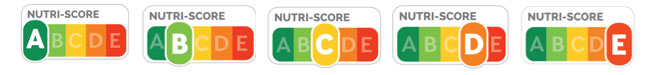


How can we quantify and predict the nutritional value of our food, to make better choices for the health of ourselves and our communities? Here, we attempt to predict the nutrition quality of a variety of foods based on features in the Open Food Facts dataset from Kaggle. We use the Nutri-Score to explicitly quantify nutrition quality: the Nutri-Score  is an official  categorization of consumables based on their nutritional value, with an A being given to the the consumabless with the highest nutritional values, and an E being given to those with the lowest values. We use the French Nutri-Score here to take advantage of the rich dataset of items with French Nutri-Score categorization.


Currently, there are explicit rule based algorithms and classifiers used to determine the Nutri-Score of any given food item. However, with different rules for added fats (such as oils and butter), cheeses, and beverages, as well as other edge cases among products, we are interested in finding a one-size-fits-all universal classifier that can accurately model the existing Nutri-Score distribution. 
We see this being potentially very useful in real time applications for grocery store customers to get live feedback about their nutrition choices. Additionally, this classifier could help grocery stores and delivery apps evaluate new items in an unbiased manner.

Different countries apply different methodologies to compute Nutri-Score, and a category agnostic predictive output could be a useful standard. A single model is also important when streaming data; we can add each new point to a single classifier, rather than updating many classifiers at once.

## **Libraries and Data**

We import standard data analysis libraries and download the Open Food Facts dataset. 

Note: make sure to upload a personal kaggle.json API key in the /content directory before running this section.



In [3]:
# imports 
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive

In [4]:
!pip install kaggle


In [5]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/


mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [6]:
!kaggle datasets download -d openfoodfacts/world-food-facts

world-food-facts.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip /content/world-food-facts.zip

Archive:  /content/world-food-facts.zip
  inflating: en.openfoodfacts.org.products.tsv  


# **Part 1: Exploratory Data Analysis**
## 1.1 First Impressions

We begin by reading in the food facts dataset from Kaggle and storing it as a dataframe.

In [7]:
food_df = pd.read_csv('/content/en.openfoodfacts.org.products.tsv', sep='\t', index_col=False, low_memory=False)

In [8]:
food_df.columns = food_df.columns.str.strip()
food_df

code                                                url  \
0       0000000003087  http://world-en.openfoodfacts.org/product/0000...   
1       0000000004530  http://world-en.openfoodfacts.org/product/0000...   
2       0000000004559  http://world-en.openfoodfacts.org/product/0000...   
3       0000000016087  http://world-en.openfoodfacts.org/product/0000...   
4       0000000016094  http://world-en.openfoodfacts.org/product/0000...   
...               ...                                                ...   
356022       99567453  http://world-en.openfoodfacts.org/product/9956...   
356023  9970229501521  http://world-en.openfoodfacts.org/product/9970...   
356024  9977471758307  http://world-en.openfoodfacts.org/product/9977...   
356025  9980282863788  http://world-en.openfoodfacts.org/product/9980...   
356026   999990026839  http://world-en.openfoodfacts.org/product/9999...   

                           creator   created_t      created_datetime  \
0       openfoodfacts-contributors  1474103866  2016-09-17T09:17:46Z   
1                  usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
2                  usda-ndb-import  1489069957  2017-03-09T14:32:37Z   
3                  usda-ndb-import  1489055731  2017-03-09T10:35:31Z   
4                  usda-ndb-import  1489055653  2017-03-09T10:34:13Z   
...                            ...         ...                   ...   
356022             usda-ndb-import  1489059076  2017-03-09T11:31:16Z   
356023                      tomato  1422099377  2015-01-24T11:36:17Z   
356024  openfoodfacts-contributors  1497018549  2017-06-09T14:29:09Z   
356025  openfoodfacts-contributors  1492340089  2017-04-16T10:54:49Z   
356026             usda-ndb-import  1489072709  2017-03-09T15:18:29Z   

       last_modified_t last_modified_datetime  \
0           1474103893   2016-09-17T09:18:13Z   
1           1489069957   2017-03-09T14:32:37Z   
2           1489069957   2017-03-09T14:32:37Z   
3           1489055731   2017-03-09T10:35:31Z   
4           1489055653   2017-03-09T10:34:13Z   
...                ...                    ...   
356022      1491244499   2017-04-03T18:34:59Z   
356023      1491244499   2017-04-03T18:34:59Z   
356024      1500730305   2017-07-22T13:31:45Z   
356025      1492340089   2017-04-16T10:54:49Z   
356026      1491244499   2017-04-03T18:34:59Z   

                                             product_name  \
0                                      Farine de blé noir   
1                          Banana Chips Sweetened (Whole)   
2                                                 Peanuts   
3                                  Organic Salted Nut Mix   
4                                         Organic Polenta   
...                                                   ...   
356022  Mint Melange Tea A Blend Of Peppermint, Lemon ...   
356023                                            乐吧泡菜味薯片   
356024                                      Biscottes bio   
356025                           Tomates aux Vermicelles    
356026                    Sugar Free Drink Mix, Peach Tea   

                           generic_name quantity  ...  \
0                                   NaN      1kg  ...   
1                                   NaN      NaN  ...   
2                                   NaN      NaN  ...   
3                                   NaN      NaN  ...   
4                                   NaN      NaN  ...   
...                                 ...      ...  ...   
356022                              NaN      NaN  ...   
356023  Leba pickle flavor potato chips     50 g  ...   
356024                              NaN     300g  ...   
356025                              NaN      67g  ...   
356026                              NaN      NaN  ...   

       fruits-vegetables-nuts_100g fruits-vegetables-nuts-estimate_100g  \
0                              NaN                                  NaN   
1                              NaN                                  NaN   
2      

We then delete all columns that only have null entries, as such columns will be of no use. A brief look at our dataframe below shows us that there are many
columns that seem to be sparse. We will have to deal with these later if they pose an issue. The hope is that they will become less sparse as we shrink the dataset to best fit our needs.

In [9]:
print("Number of columns before dropping null columns : %s" % (len(food_df.columns)))
food_df.dropna(axis = 1, how='all', inplace=True)
print("Number of columns after dropping null columns : %s" % (len(food_df.columns)))

Number of columns before dropping null columns : 163
Number of columns after dropping null columns : 147


The following is a visualization of the correlations between our numerical variables. There are numerous pairs with strong negative
or positive correlations between them.  We may want to remove variables to reduce the collinearity in our models. This chart may not be overly informative due to what looks like a high number of null values in the dataframe. However, it will be a good baseline to compare to once we have wittled down the number of null values and the number of columns.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


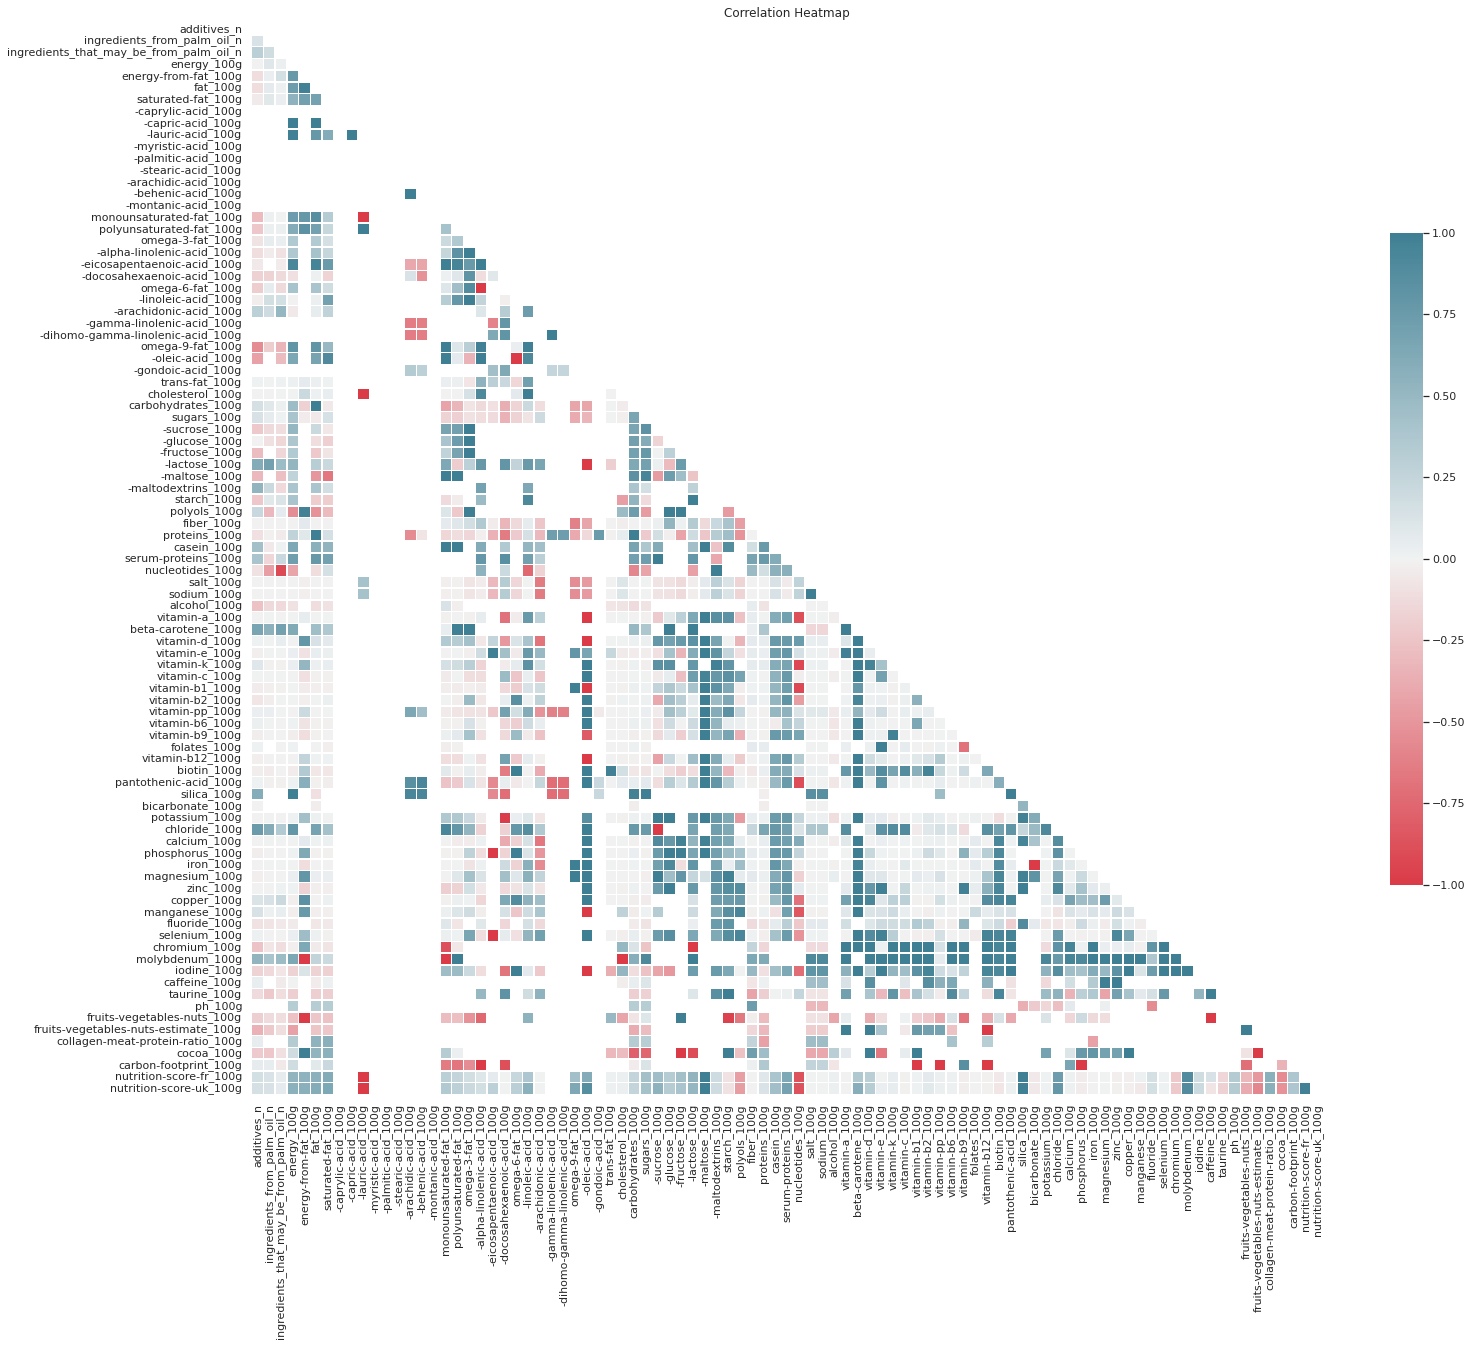

In [10]:
from string import ascii_letters
correlation_matrix = food_df.corr()
sns.set(style = "white")
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))
corr = correlation_matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(24, 24))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
plt.title("Correlation Heatmap")
sns.set(font_scale=0.1)
plt.show()

## 1.2 Target Variable Analysis

We now focus on our candidate target variable: nutrition_grade_fr. We note that there are two other similar non-categorical variables, nutrition-score-fr_100g, and nutrition-score-uk_100g. The first of these, nutrition-score-fr_100g is perfectly correlated with our target because there is a one to one mapping between the scores and the grades. We know this from the relevant documentation. Since we prefer to do classification models, we have chosen the nutrition grade (also known as the Nutri-Score) as our target. It then becomes of interest what to do with nutrition-score-uk_100g. As the code below shows, these columns are not identical but do have the same number of non-null entries. We then visualize the score distributions.

In [11]:
print("The columns are identical : %s" % (food_df['nutrition-score-fr_100g'].equals(food_df['nutrition-score-uk_100g'])))
print(len(food_df[['nutrition-score-fr_100g']].dropna()))
print(len(food_df[['nutrition-score-uk_100g']].dropna()))

The columns are identical : False
254856
254856


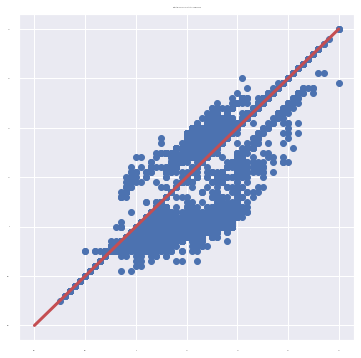

In [11]:
plt.subplots(figsize=(6, 6))
plt.scatter(food_df['nutrition-score-fr_100g'], food_df['nutrition-score-uk_100g'])
plt.plot([-20, 40], [-20, 40], 'r', linewidth=3)
plt.title("Nutrition Score UK vs Nutrition Score France")
plt.show()

This plot shows a strong linear relationship between the nutrition scores from France and the nutrition scores from the UK, with many points falling directly on the line y=x. However, there is a discrepancy between the way France and the UK give scores for some food items. This shows clearly that there is not unanimity on scoring or grading food.

At this point, we will drop nutrition-score-fr_100kg because it is more or less equivalent to our target. We similarly drop nutrition-score-uk_100kg because we want to make a robust model and when classifying new data points, it is not a given that we will get the nutrition score from the UK.

In [12]:
food_df.drop('nutrition-score-uk_100g', axis=1, inplace=True)
food_df.drop('nutrition-score-fr_100g', axis=1, inplace=True)

Then, since we are only interested in datapoints that have a nutrition grade, we will get rid of all rows that do not have a nutrition grade, as there are far too many null occurences for imputation to be practical.

In [13]:
print("Number of rows with null nutrition grade : %s" % (len(food_df)-len(food_df[['nutrition_grade_fr']].dropna())))

Number of rows with null nutrition grade : 101171


In [13]:
food_df.dropna(subset=['nutrition_grade_fr'], inplace=True)
print("Remaining number of rows : %s" % (len(food_df)))

Remaining number of rows : 254856


Here we take a look at the distribution of grades to make sure that what we are doing is viable and that the training will not be biased to predict towards one category merely as a result of its relative frequency.

[Text(0.5, 1.0, 'Grade Frequencies')]

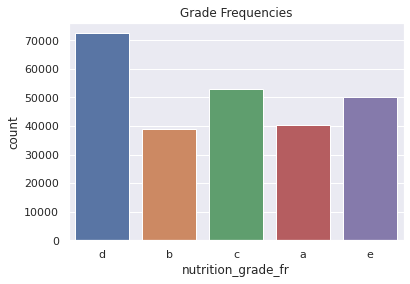

In [14]:
sns.set(font_scale=1)
p = sns.countplot(x='nutrition_grade_fr', data=food_df)
p.set(title='Grade Frequencies')


In [15]:
food_df[["nutrition_grade_fr"]].value_counts(normalize=True)

nutrition_grade_fr
d                     0.284223
c                     0.207450
e                     0.197115
a                     0.158144
b                     0.153067
dtype: float64

There are relatively more grades of 'd' than any of the others. However, the proportions don't look wildly unbalanced. We will keep an eye on this as we continue to preprocess and may make a manual adjustment at the end if necessary, in order to maintain class balance.

## 1.3 Cross-Country Comparison

One of the things that we mentioned an interest in doing in our project proposal was comparing our target variable distributions across countries. This will only be revealing for countries that have a sufficient number of datapoints. The countries that don't have many datapoints may end up "confusing" our model when classifying for countries that do have many datapoints, especially if there is a linkage between the reason that countries have few datapoints, and the grades they are more likely to get. We therefore take it upon ourselves to delete countries that don't have at least 100 datapoints.

In this section, we find which countries have at least 100 data points and drop those that do not. We print the list of remaining countries or regions. We then join with the original dataframe.

In [16]:
countries = food_df.groupby('countries_en', as_index=False).count()
for i in range(len(countries)) :
  if countries.at[i, 'code'] < 100 :
    countries.drop(i, inplace=True)
countries.reset_index(drop=True, inplace=True)
for i in range(len(countries)) :
  print("%s : %s" % (countries.at[i, 'countries_en'], countries.at[i, 'code']))

food_df = countries[['countries_en']].merge(food_df, how='left', on='countries_en')

Australia : 496
Belgium : 601
Belgium,France : 623
Canada : 194
France : 89045
France,Germany : 276
France,Spain : 221
France,Switzerland : 1299
France,United Kingdom : 432
France,United States : 236
Germany : 4813
Germany,Switzerland : 193
Hungary : 145
Italy : 374
Netherlands : 250
Portugal : 341
Serbia : 209
Spain : 2564
Sweden : 251
Switzerland : 8865
United Kingdom : 1524
United States : 139076


We attempt to illustrate the above print statement graphically. The labels don't fit well. However, the tallest bar below (in pink) is the United States,
and the second tallest (yellow) is France. These two countries have
by far the most data. A look at the print statement above tells us that the countries that have at least 100 datapoints are all first world countries in Europe or the western Anglosphere. When filtering out other countries, we only lost a few thousand datapoints. It is important to keep this in mind so we know whether our model will be robust to lower income countries.

[Text(0.5, 1.0, 'Country datapoint Frequencies')]

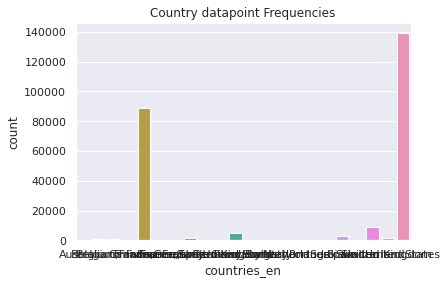

In [17]:
p = sns.countplot(x='countries_en', data=food_df)
p.set(title='Country datapoint Frequencies')

Here we convert nutrition_grade_fr to a numerical variable. This will be necessary for the final analysis and will help us to properly visualize the distribution of grades across countries.

In [18]:
food_df['nutrition_grade_fr'] = food_df['nutrition_grade_fr'].str.strip()
food_df = food_df.assign(nutrition_grade_fr = lambda dataframe: dataframe['nutrition_grade_fr'].map(lambda nutrition_grade_fr: 1.0 if nutrition_grade_fr == 'a' else 2.0 if nutrition_grade_fr == 'b' else 3.0 if nutrition_grade_fr == 'c' else 4.0 if nutrition_grade_fr == 'd' else 5.0 if nutrition_grade_fr == 'e' else 6.0)) 
print(food_df['nutrition_grade_fr'].unique())

[5. 4. 2. 3. 1.]


Below we examine a violin plot with the countries on the x axis and the nutrition grade numbers as the y axis. While the graph does not perfectly illustrate our distribution because it treats nutrition grade as continuous when in fact it is discrete, it gives us a good idea of the grade distribution in each country or set of countries. Certain country categories such as the U.S., Switzerland, France, and the United Kingdom seem to have relatively uniform distributions across the grades. Other country categories do not do as well however, with all of Australia's foods having a B grade and all of the foods in "France,Spain" being given either a D or an E grade. Since different countries have different distributions, it suggests that countries may be a decent predictor of grade. However, we do have to worry about how robust the model will be to new entries in places like Australia, where the model may be biased to predict a B grade.

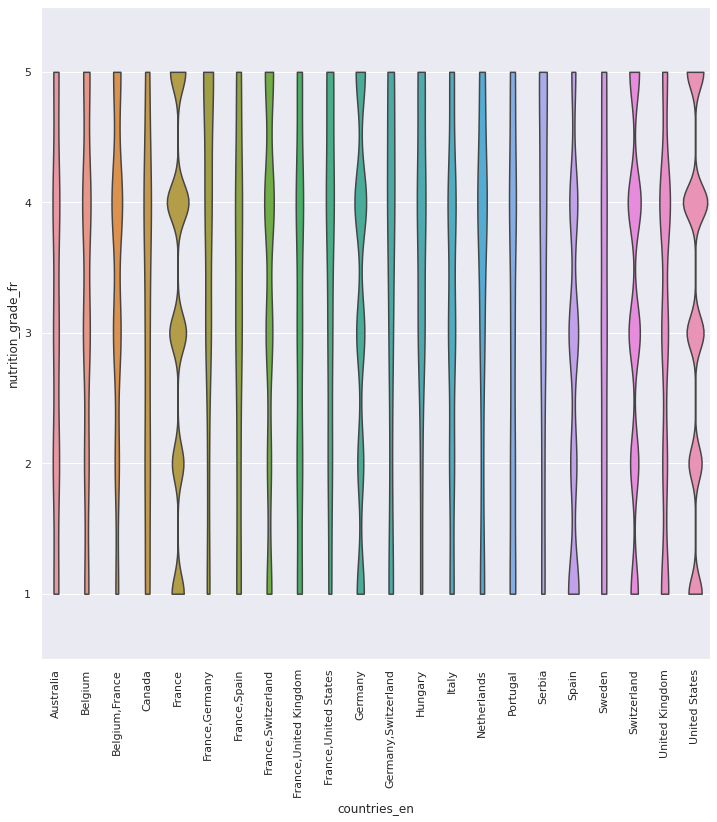

In [19]:
plt.subplots(figsize=(12, 12))
plt.xticks(rotation='vertical')
plt.ylim([0.5, 5.5])
fig = sns.violinplot(x="countries_en", y="nutrition_grade_fr", data=food_df, cut=0,inner=None)


## 1.4 Dropping Null and Sparse Columns

After our past adjustments, we once again attempt to drop any columns that are completely null, and the print output below indicates that there were some.

In [20]:
print("Number of columns before dropping null columns : %s" % (len(food_df.columns)))
food_df.dropna(axis=1,how='all', inplace=True)
print("Number of columns after dropping null columns : %s" % (len(food_df.columns)))

Number of columns before dropping null columns : 145
Number of columns after dropping null columns : 134


A further look seems to show that there are still sparse columns so we now will try to deal with those. Below we print the number of non-null datapoints in
each column.

In [21]:
#TODO Get rid of columns that are too sparse to be used during machine learning
for column_name in food_df.columns :
  print("Number of non-null data points in %s : %s" % (column_name, len(food_df[[column_name]].dropna())))

Number of non-null data points in countries_en : 252028
Number of non-null data points in code : 252028
Number of non-null data points in url : 252028
Number of non-null data points in creator : 252027
Number of non-null data points in created_t : 252028
Number of non-null data points in created_datetime : 252027
Number of non-null data points in last_modified_t : 252028
Number of non-null data points in last_modified_datetime : 252028
Number of non-null data points in product_name : 249337
Number of non-null data points in generic_name : 41898
Number of non-null data points in quantity : 72440
Number of non-null data points in packaging : 62415
Number of non-null data points in packaging_tags : 62415
Number of non-null data points in brands : 247255
Number of non-null data points in brands_tags : 247245
Number of non-null data points in categories : 72529
Number of non-null data points in categories_tags : 72529
Number of non-null data points in categories_en : 72529
Number of non-nul

Many of these columns have too few datapoints to be good predictors in a model. As some columns have as man as 252000 entries, we will drop all columns that do not have at least 100,000 datapoints and see where we stand from there. 

In [22]:
for column_name in food_df.columns :
  if len(food_df[[column_name]].dropna()) < 100000 :
         food_df.drop(column_name, axis=1, inplace=True)
for column_name in food_df.columns :
  print("Number of non-null data points in %s : %s" % (column_name, len(food_df[[column_name]].dropna())))

Number of non-null data points in countries_en : 252028
Number of non-null data points in code : 252028
Number of non-null data points in url : 252028
Number of non-null data points in creator : 252027
Number of non-null data points in created_t : 252028
Number of non-null data points in created_datetime : 252027
Number of non-null data points in last_modified_t : 252028
Number of non-null data points in last_modified_datetime : 252028
Number of non-null data points in product_name : 249337
Number of non-null data points in brands : 247255
Number of non-null data points in brands_tags : 247245
Number of non-null data points in countries : 252028
Number of non-null data points in countries_tags : 252028
Number of non-null data points in ingredients_text : 227792
Number of non-null data points in serving_size : 177674
Number of non-null data points in additives_n : 227792
Number of non-null data points in additives : 227766
Number of non-null data points in additives_tags : 140867
Number

Importantly, we notice that after this last step, the categories predictor is gone. This means our ML models in the next section will not be able to use whether or note the item is a food, beverage, oil, cheese, etc. when it is classifying the foods. This will be a major differentiation between our model and existing models.

Before dropping any more null points, it will be instructive to look at the updated correlation matrix to see if there are any columns (hopefully some of the sparser ones) that we can drop.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


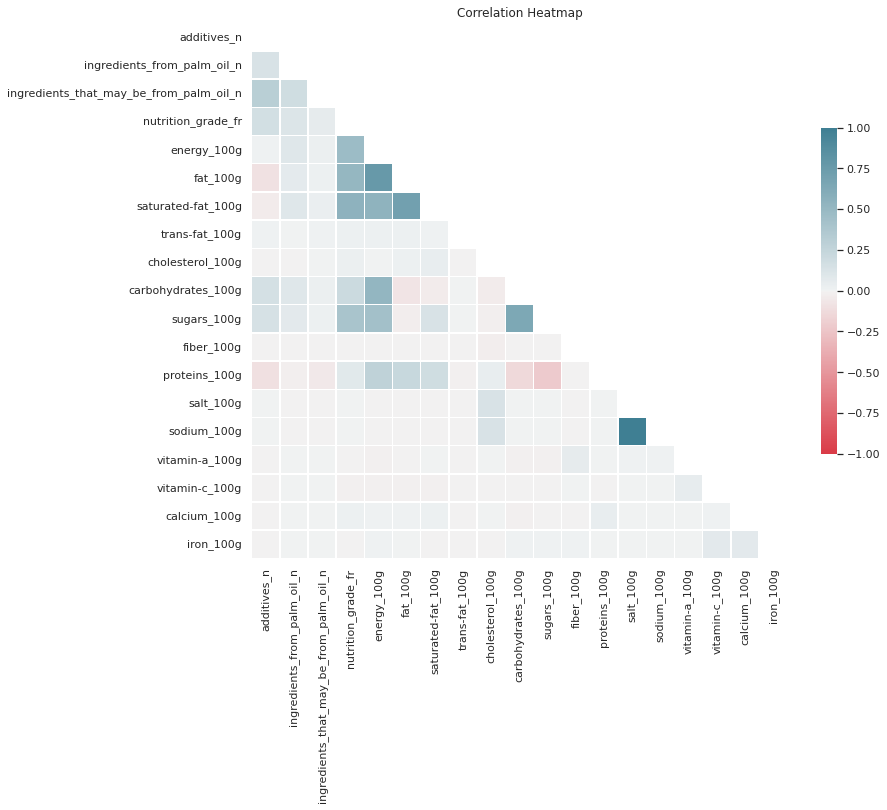

In [23]:
# TO-DO: Get the correlation matrix
from string import ascii_letters
correlation_matrix = food_df.corr()
sns.set(style = "white")
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))
corr = correlation_matrix
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(12, 12))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
plt.title("Correlation Heatmap")
sns.set(font_scale=1)
plt.show()

Reassuringly, the updated correlation matrix has far few dark colors than the previous one. It does show a high correlation between salt and sodium. Referencing the relevant documentation, we are told that sodium and salt are direct multiples. Sodium is directly used to compute nutrition score and grade while salt is not, so we will keep sodium and drop salt.

In [24]:
food_df.drop('salt_100g', axis=1, inplace=True)

Finally, in looking for categorical variables to drop, we will want to get rid of most of those that are "identifiers." That is, we would like to drop those that have a unique value for each datapoint, as they are unlikely to be useful in a general
machine learning model.

In [25]:
for column_name in food_df.columns :
  if food_df[column_name].value_counts().count() > 1000:
    print("Number of unique data points in %s : %s" % (column_name, food_df[column_name].value_counts().count()))

Number of unique data points in code : 252028
Number of unique data points in url : 252028
Number of unique data points in creator : 2582
Number of unique data points in created_t : 153185
Number of unique data points in created_datetime : 153184
Number of unique data points in last_modified_t : 148624
Number of unique data points in last_modified_datetime : 148624
Number of unique data points in product_name : 185146
Number of unique data points in brands : 46885
Number of unique data points in brands_tags : 40418
Number of unique data points in ingredients_text : 196309
Number of unique data points in serving_size : 23203
Number of unique data points in additives : 188588
Number of unique data points in additives_tags : 34078
Number of unique data points in additives_en : 34078
Number of unique data points in energy_100g : 3754
Number of unique data points in fat_100g : 3392
Number of unique data points in saturated-fat_100g : 2252
Number of unique data points in carbohydrates_100g :

From this, we see that code and url are both identifiers so we drop the latter. We also notice several duplicates such as last_modified_t and last_modified_datetime, brands and brands_tags, and additives, additivies_tags,
and additives_en. There were several above such as those that involved state and country,  so we drop them all here.

In [26]:
food_df.drop(['url', 'last_modified_t', 'brands_tags', 'additives_tags', 'additives_en', 'countries', 'countries_tags', 'states', 'states_tags', 'created_t'], axis=1, inplace=True)

Looking at the non-null datapoints of the remaining columns below, we still have an issue of too much sparsity.

In [27]:
for column_name in food_df.columns :
  print("Number of non-null data points in %s : %s" % (column_name, len(food_df[[column_name]].dropna())))

Number of non-null data points in countries_en : 252028
Number of non-null data points in code : 252028
Number of non-null data points in creator : 252027
Number of non-null data points in created_datetime : 252027
Number of non-null data points in last_modified_datetime : 252028
Number of non-null data points in product_name : 249337
Number of non-null data points in brands : 247255
Number of non-null data points in ingredients_text : 227792
Number of non-null data points in serving_size : 177674
Number of non-null data points in additives_n : 227792
Number of non-null data points in additives : 227766
Number of non-null data points in ingredients_from_palm_oil_n : 227792
Number of non-null data points in ingredients_that_may_be_from_palm_oil_n : 227792
Number of non-null data points in nutrition_grade_fr : 252028
Number of non-null data points in states_en : 252028
Number of non-null data points in energy_100g : 251860
Number of non-null data points in fat_100g : 236007
Number of non

One way to solve this issue is to call dropna on 'vitamin-a_100g' in hopes of getting a fuller dataset. It took trial and error (which we have omitted) to discover that this was a good column to drop nulls from.

In [28]:
food_df.dropna(subset=['vitamin-a_100g'], inplace=True)
food_df
for column_name in food_df.columns :
  print("Number of non-null data points in %s : %s" % (column_name, len(food_df[[column_name]].dropna())))

Number of non-null data points in countries_en : 132026
Number of non-null data points in code : 132026
Number of non-null data points in creator : 132026
Number of non-null data points in created_datetime : 132026
Number of non-null data points in last_modified_datetime : 132026
Number of non-null data points in product_name : 131903
Number of non-null data points in brands : 131243
Number of non-null data points in ingredients_text : 131635
Number of non-null data points in serving_size : 131700
Number of non-null data points in additives_n : 131635
Number of non-null data points in additives : 131630
Number of non-null data points in ingredients_from_palm_oil_n : 131635
Number of non-null data points in ingredients_that_may_be_from_palm_oil_n : 131635
Number of non-null data points in nutrition_grade_fr : 132026
Number of non-null data points in states_en : 132026
Number of non-null data points in energy_100g : 132026
Number of non-null data points in fat_100g : 131901
Number of non

## 1.5 Imputation and Categorical to Numeric Conversion 

It now looks like we have a relatively even dataset with small numbers of null values in numerous columns. At this point, we can fix that with imputation. We now give a final check to see if we have a class balance. The results below seem to support that our classes are relatively well balanced, so we may move forward.

[Text(0.5, 1.0, 'Grade Frequencies')]

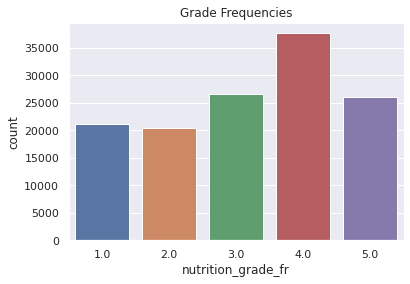

In [29]:
sns.set(font_scale=1)
p = sns.countplot(x='nutrition_grade_fr', data=food_df)
p.set(title='Grade Frequencies')

In [30]:
food_df[["nutrition_grade_fr"]].value_counts(normalize=True)

nutrition_grade_fr
4.0                   0.285459
3.0                   0.201695
5.0                   0.198006
1.0                   0.160294
2.0                   0.154545
dtype: float64

Here we convert our categorical variables to factors with -1 replacing null values. 

In [31]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#Put all numeric columns into newdf1 and all categorical into newdf2
newdf1 = food_df.select_dtypes(include=numerics)
newdf2 =  food_df.drop(newdf1.columns, axis=1)
newdf2 = newdf2.apply(lambda x: pd.factorize(x)[0])
newdf2.reset_index(drop=True, inplace=True)


Here we do mean imputation of our initial set of numeric variables. Since many of the columns have null values, we have decided to not add columns that would control for this imputation because we worry that it would leave us with too many predictors.

In [32]:
newdf1 = newdf1.apply(lambda x: x.fillna(x.mean()),axis=0)
newdf1.reset_index(drop=True, inplace=True)

Finally, we get our pre-processed dataframe!

In [33]:
food_df_final = pd.concat([newdf1,newdf2], axis=1,join='outer')

In [34]:
print(food_df_final.columns)

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'nutrition_grade_fr',
       'energy_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g',
       'cholesterol_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g',
       'calcium_100g', 'iron_100g', 'countries_en', 'code', 'creator',
       'created_datetime', 'last_modified_datetime', 'product_name', 'brands',
       'ingredients_text', 'serving_size', 'additives', 'states_en'],
      dtype='object')


Next, we evaluate several features that we think may be important in impacting nutrition score. We explore histograms of various numerical parameters, partitioned by category. These both agree with conventional nutrition thinking. 

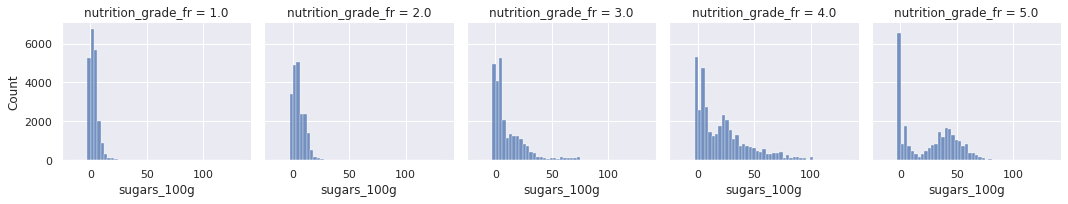

In [36]:
sns.displot(
    food_df_final, x="sugars_100g", col="nutrition_grade_fr",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True), 
)

The distribtutions of sugar in each nutrition grade level above show us that sugar is increasing in grade. That is, a higher amount of sugar tends to correlate with a lower nutrition grade. This will likely turn out to be an important predictor for nutrition grade. 

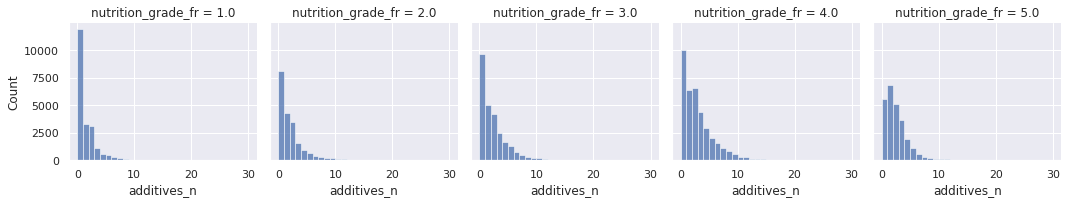

In [ ]:
sns.displot(
    food_df_final, x="additives_n", col="nutrition_grade_fr",
    binwidth=1, height=3, facet_kws=dict(margin_titles=True), 
)

The distribution of additives in each nutrition grade level above show us that additives are relatively evenly distributed across grades. This feature is therefore unlikely to be a good predictor for nutrition grade. Typically, we think of additives being unhealthy and non-nutritious. At least in the context of this dataset however, this does not seem to be the case.

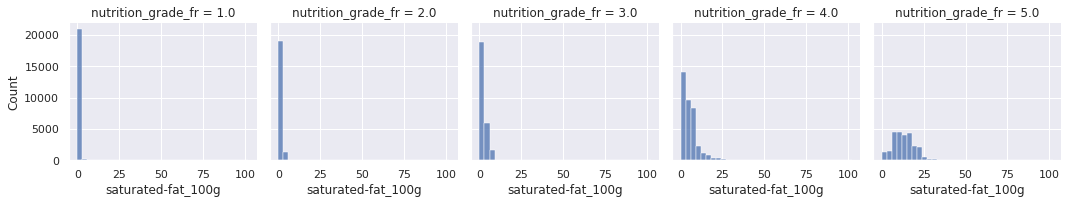

In [38]:
sns.displot(
    food_df_final, x="saturated-fat_100g", col="nutrition_grade_fr",
    binwidth=3, height=3, facet_kws=dict(margin_titles=True), 
)

Saturated fat, like sugar shows larger amounts of saturated fat correlating with worse nutrition grades. This, like sugar will likely be a strong predictor of nutrition grade. We note that conventional thinking would also lead us to the conclusion that less nutritious foods contain more saturated fat or sugar, and more nutritious foods contain less.

# **Part 2: Modeling**

In [36]:
#Creating a copy for the Modelling Section
modelling_df = food_df_final.copy()


In [37]:
#Saving the columns for later use
cols = modelling_df.columns

In [38]:
#Converting to columns to float32
for col in cols:
    modelling_df[col] = np.float32(modelling_df[col])

In [39]:
#Extracting Features and Labels
import numpy as np
labels = np.array(modelling_df['nutrition_grade_fr'])
features= modelling_df.drop('nutrition_grade_fr', axis = 1)

#Storing the set of features for potential later use
features_storage = features.copy()
print(features.columns)
feature_list = list(features.columns)
features = np.array(features)

Index(['additives_n', 'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g',
       'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g',
       'iron_100g', 'countries_en', 'code', 'creator', 'created_datetime',
       'last_modified_datetime', 'product_name', 'brands', 'ingredients_text',
       'serving_size', 'additives', 'states_en'],
      dtype='object')


In [40]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [41]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (99019, 28)
Training Labels Shape: (99019,)
Testing Features Shape: (33007, 28)
Testing Labels Shape: (33007,)


##2.0 Decision Tree

It is useful to use a baseline classifier such as a decision tree so we can see how accurately we already can predict our target with a less complex model. We can then increase the complexity of the model with the hopes of also increasing test accuracy. The initial decision tree we use has default parameters meaning there is no max depth and the tree has the ability to split a node that only contains 2 datapoints, during training. Changes in impurity will be measured with gini impurity rather than information gain.

In [45]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(random_state=42)
clf = clf.fit(train_features,train_labels)



In [46]:
from sklearn import metrics
predictions = clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))


Accuracy: 0.9321053109946374


Our decision tree already has a remarkably high degree of accuracy -- 93%! We note that the low minimum split parameter and the lack of a max depth may make our tree prone to overfitting. We will try and make adjustments to see if there is overfitting in subsequent sections. Directly below we show several methods of comparing true and false positive and negative rates. All of them show that for each class, our model is already doing a stellar job of classifying the foods to appropriate grades.

In [47]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = clf.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.95      0.95      0.95      5421
     class 1       0.89      0.90      0.89      5000
     class 2       0.90      0.90      0.90      6674
     class 3       0.94      0.94      0.94      9404
     class 4       0.96      0.96      0.96      6508

    accuracy                           0.93     33007
   macro avg       0.93      0.93      0.93     33007
weighted avg       0.93      0.93      0.93     33007



Belowr we see the feature importance. Saturated fat (per 100g) is the most important followed closely by sodium, with sugars, fibers, and energy also having relatively high importance. Interestingly, many of the features have no importance at all and are not used by the high accuracy model. We will watch closely to see if this trend continues in future models.

In [48]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: saturated-fat_100g   Importance: 0.26
Variable: sodium_100g          Importance: 0.24
Variable: sugars_100g          Importance: 0.16
Variable: fiber_100g           Importance: 0.12
Variable: energy_100g          Importance: 0.09
Variable: proteins_100g        Importance: 0.04
Variable: fat_100g             Importance: 0.03
Variable: carbohydrates_100g   Importance: 0.01
Variable: iron_100g            Importance: 0.01
Variable: additives_n          Importance: 0.0
Variable: ingredients_from_palm_oil_n Importance: 0.0
Variable: ingredients_that_may_be_from_palm_oil_n Importance: 0.0
Variable: trans-fat_100g       Importance: 0.0
Variable: cholesterol_100g     Importance: 0.0
Variable: vitamin-a_100g       Importance: 0.0
Variable: vitamin-c_100g       Importance: 0.0
Variable: calcium_100g         Importance: 0.0
Variable: countries_en         Importance: 0.0
Variable: code                 Importance: 0.0
Variable: creator              Importance: 0.0
Variable: created_datetim

In [49]:
!pip install graphviz

!pip install pydotplus

Below we have a visualization of the tree. It is quite large and has many leaves. We will attempt to make sure it does not overfit in the following sections.

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0778005 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.0778005 to fit



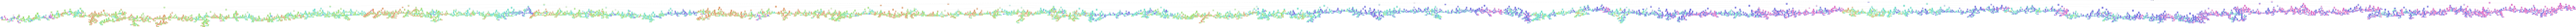

In [50]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features_storage.columns,class_names=['class 0', 'class 1','class 2','class 3','class 4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Decision Tree.png')
Image(graph.create_png())

## 2.1 Lower max depth Decision Tree

Here we somewhat naively try to cut down on the max depth of the decision tree. It is unclear if it was overfitting in the previous model thus far. However, it seems as if it is definitely underfitting in this model with an accuracy of only 0.72 displayed below.

In [51]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf = clf.fit(train_features,train_labels)

In [52]:
from sklearn import metrics
predictions = clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))


Accuracy: 0.7234828975671828


In this weak model, the largest emphasis is placed on saturated fat, followed by sodium and sugars.

In [53]:
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: saturated-fat_100g   Importance: 0.4
Variable: sodium_100g          Importance: 0.29
Variable: sugars_100g          Importance: 0.16
Variable: fiber_100g           Importance: 0.11
Variable: energy_100g          Importance: 0.02
Variable: fat_100g             Importance: 0.02
Variable: additives_n          Importance: 0.0
Variable: ingredients_from_palm_oil_n Importance: 0.0
Variable: ingredients_that_may_be_from_palm_oil_n Importance: 0.0
Variable: trans-fat_100g       Importance: 0.0
Variable: cholesterol_100g     Importance: 0.0
Variable: carbohydrates_100g   Importance: 0.0
Variable: proteins_100g        Importance: 0.0
Variable: vitamin-a_100g       Importance: 0.0
Variable: vitamin-c_100g       Importance: 0.0
Variable: calcium_100g         Importance: 0.0
Variable: iron_100g            Importance: 0.0
Variable: countries_en         Importance: 0.0
Variable: code                 Importance: 0.0
Variable: creator              Importance: 0.0
Variable: created_datetime   

Below, we viualize this tree which is far simpler than the previous one.

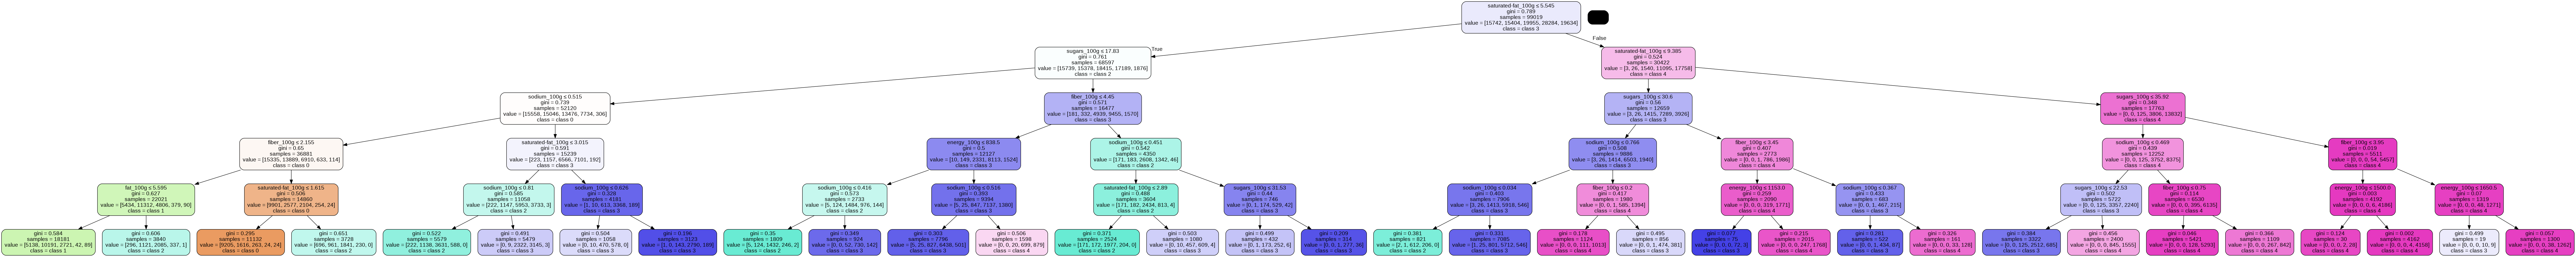

In [54]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = features_storage.columns,class_names=['class 0', 'class 1','class 2','class 3','class 4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('Optimized Decision Tree.png')
Image(graph.create_png())

### 2.1.1 Hyper Parameter Tuning for Decision Tree

We will now search for the optimized max_depth and minimum samples split for the tree using grid search cross validation. This method shows us that a max depth of 23 is optimal and that the minimum samples split of 2 is also best.

In [55]:
#1070 seconds
from sklearn.model_selection import GridSearchCV

param_dict = {
    'max_depth' : range(10,30),
    'min_samples_split': range(2,10),
}
decision_tree = DecisionTreeClassifier(random_state=42)
grid = GridSearchCV(decision_tree, param_grid = param_dict, cv=5, verbose=1, n_jobs=-1)
grid.fit(train_features,train_labels)

Fitting 5 folds for each of 160 candidates, totalling 800 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': range(10, 30),
                         'min_samples_split': range(2, 10)},
             verbose=1)

In [56]:
grid.best_params_

{'max_depth': 19, 'min_samples_split': 2}

In [57]:
grid.best_estimator_

# The best parameters are max depth: 19 and min_samples_split : 2

DecisionTreeClassifier(max_depth=19, random_state=42)

### 2.1.2 Optimized Decision Tree

After putting the optimal parameters into the model, we get a marginally lower accuracy which is likely to do with the randomness in the modeling process. Overall, there is not a big difference between this optimized model and our initial model, indicating that we were probably not overfitting initially. The feature importance is also almost identical to the initial model.

In [58]:
from sklearn.tree import DecisionTreeClassifier 
clf = DecisionTreeClassifier(max_depth= 19, random_state=42)
clf = clf.fit(train_features,train_labels)
from sklearn import metrics
predictions = clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = clf.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))
# Get numerical feature importances
importances = list(clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];




###Citation for the models: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc
###, https://mljar.com/blog/visualize-decision-tree/, https://towardsdatascience.com/gridsearchcv-for-beginners-db48a90114ee,https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

Accuracy: 0.9318023449571303
              precision    recall  f1-score   support

     class 0       0.95      0.95      0.95      5421
     class 1       0.89      0.89      0.89      5000
     class 2       0.91      0.90      0.90      6674
     class 3       0.94      0.94      0.94      9404
     class 4       0.96      0.96      0.96      6508

    accuracy                           0.93     33007
   macro avg       0.93      0.93      0.93     33007
weighted avg       0.93      0.93      0.93     33007

Variable: saturated-fat_100g   Importance: 0.26
Variable: sodium_100g          Importance: 0.25
Variable: sugars_100g          Importance: 0.16
Variable: fiber_100g           Importance: 0.13
Variable: energy_100g          Importance: 0.09
Variable: proteins_100g        Importance: 0.04
Variable: fat_100g             Importance: 0.02
Variable: carbohydrates_100g   Importance: 0.01
Variable: additives_n          Importance: 0.0
Variable: ingredients_from_palm_oil_n Importance: 0

##2.2 Random Forest Model

Due to how well our decision tree just did, it makes sense to now expect even higher accuracy from an ensemble of decision trees. Therefore, we will bring in the random forest model. Once again we will start by simply using the default parameters of the RandomForestClassifier from sklearn. This has no max depth and uses 100 trees in the forest.

In [59]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
rf = RandomForestClassifier(random_state=42)
# Train the model on training data
rf.fit(train_features, train_labels);

In [60]:
from sklearn import metrics
predictions = rf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))

Accuracy: 0.9446784015511861


As seen above, the model does not disappoint and we have achieved a marginal increase in accuracy -- which is now up to 94% -- from the decision tree model! Below, we once again show a number of metrics measuring ratios between true and false negatives and positives. These numbers are similar to that of the decision tree, but are generally a little better.

In [61]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = rf.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      5421
     class 1       0.92      0.91      0.91      5000
     class 2       0.92      0.93      0.92      6674
     class 3       0.94      0.96      0.95      9404
     class 4       0.97      0.96      0.97      6508

    accuracy                           0.94     33007
   macro avg       0.94      0.94      0.94     33007
weighted avg       0.94      0.94      0.94     33007



Finally, we again investigate the importance of the features in our model. Saturated fat and sodium are still the two most important features. We find that the random forest has put less weight on them than did the decision tree however. Energy, sugars, and fibers remain important. Fifth in importance is fat which makes sense since we know from our EDA that it is well correlated with saturated fat. Carbohydrates, and protein are the remaining three that have at least 0.05 importance. Carbohydrates are well correlated with sugars and so it is not surprising that they are important. Protein is not well correlated with any other predictors so we now know it may have some importance in prediction. A number of other features are non-zero but have very low importance of < 0.05. Only a few features have actually been zeroed out under the random forest model. 

In [62]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: sodium_100g          Importance: 0.15
Variable: saturated-fat_100g   Importance: 0.14
Variable: sugars_100g          Importance: 0.11
Variable: energy_100g          Importance: 0.09
Variable: fat_100g             Importance: 0.08
Variable: fiber_100g           Importance: 0.08
Variable: carbohydrates_100g   Importance: 0.05
Variable: proteins_100g        Importance: 0.05
Variable: calcium_100g         Importance: 0.03
Variable: additives_n          Importance: 0.02
Variable: cholesterol_100g     Importance: 0.02
Variable: iron_100g            Importance: 0.02
Variable: serving_size         Importance: 0.02
Variable: additives            Importance: 0.02
Variable: vitamin-a_100g       Importance: 0.01
Variable: vitamin-c_100g       Importance: 0.01
Variable: code                 Importance: 0.01
Variable: created_datetime     Importance: 0.01
Variable: last_modified_datetime Importance: 0.01
Variable: product_name         Importance: 0.01
Variable: brands               Importa

### 2.2.1 Hyper Parameter Tuning for Random Forest

We now test different max depths and forest sizes to see if we can increase our accuracy by a significan amount. Increasing forest size will almost definitely increase accuracy but it is not clear if that amount will make much of a difference. Again using grid search cross validation, we find optimal parameters of a max depth of 25 (the max depth we tried) and a forest size of 1000 (the max size we tried). 

Note: the following code takes over an hour to run so we have commented it out. We do have the result from it. 

In [63]:
# from sklearn.model_selection import GridSearchCV

# param_dict = {
#     'max_depth' : [15,20,25],
#     'n_estimators': [100, 200,400,600,800,1000],
# }
# random_forest = RandomForestClassifier(random_state=42)
# grid = GridSearchCV(random_forest, param_grid = param_dict, cv=5, verbose=1, n_jobs=-1)
# grid.fit(train_features,train_labels)
# print(grid.best_params_)
# print(grid.best_estimator_)


# The best parameters are max depth: 25 and n_estimators : 1000

### 2.2.2 Optimized Random Forest

Running the model with these optimized parameters, we again see only very small improvements in our accuracy. This is probably a result of a forest of size 1000 being far beyond the knee point for accuracy. Once again, there are virtually no differences between the other metrics of performance or the feature importance.

In [42]:
#400 secs
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(max_depth= 25, n_estimators= 1000, random_state=42)
# Train the model on training data
rf.fit(train_features, train_labels);
from sklearn import metrics
predictions = rf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = rf.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy: 0.9454055200412034
              precision    recall  f1-score   support

     class 0       0.97      0.95      0.96      5421
     class 1       0.92      0.91      0.91      5000
     class 2       0.92      0.93      0.92      6674
     class 3       0.94      0.96      0.95      9404
     class 4       0.97      0.96      0.97      6508

    accuracy                           0.95     33007
   macro avg       0.95      0.94      0.94     33007
weighted avg       0.95      0.95      0.95     33007

Variable: sodium_100g          Importance: 0.15
Variable: saturated-fat_100g   Importance: 0.14
Variable: sugars_100g          Importance: 0.11
Variable: energy_100g          Importance: 0.1
Variable: fat_100g             Importance: 0.08
Variable: fiber_100g           Importance: 0.08
Variable: carbohydrates_100g   Importance: 0.05
Variable: proteins_100g        Importance: 0.05
Variable: calcium_100g         Importance: 0.03
Variable: additives_n          Importance: 0.02
Var

##2.3 AdaBoost Model



Boosting may do better than a random forest in some cases. Using an AdaBoost model with a decision stump as our base classifier, a learning rate of 1, and 50 iterations, we see if this ensemble method offers a better result than our currently most accurate classifier.

In [43]:
from sklearn.ensemble import AdaBoostClassifier
adamodel = AdaBoostClassifier(random_state=42)
adamodel.fit(train_features, train_labels)

AdaBoostClassifier(random_state=42)

In [44]:
from sklearn import metrics
predictions = adamodel.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))

Accuracy: 0.6305329172599752


The accuracy of this method is much lower than that of the previous two. This may suggest that the true hypothesis class is closer to that of a deep decision tree. Below, the model does worse on every metric than do the previous two models meaning that the classification is weaker in every aspect.

In [45]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = adamodel.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.83      0.75      0.79      5421
     class 1       0.61      0.66      0.64      5000
     class 2       0.59      0.80      0.68      6674
     class 3       0.55      0.68      0.61      9404
     class 4       0.89      0.26      0.40      6508

    accuracy                           0.63     33007
   macro avg       0.69      0.63      0.62     33007
weighted avg       0.68      0.63      0.61     33007



Once again looking at importance of our predictors, we see that saturated fat, sugars, and states are tied as the most important ones. After that, energy, sodium, fiber, protein, and additives also are greater than 0.05 importance. Based on our previous models, none of these is surprising except perhaps states. States is a (converted) categorical variable that indicates the status of whether or not a given food item has things like completed nutrition facts, completed ingredients, completed expiration date, etc. The fact that this is important tells us that the amount of data for each item may have predictive power in telling us its nutrition grade. 

In [46]:
# Get numerical feature importances
importances = list(adamodel.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: saturated-fat_100g   Importance: 0.14
Variable: sugars_100g          Importance: 0.14
Variable: states_en            Importance: 0.14
Variable: energy_100g          Importance: 0.12
Variable: sodium_100g          Importance: 0.12
Variable: fiber_100g           Importance: 0.08
Variable: proteins_100g        Importance: 0.08
Variable: additives_n          Importance: 0.06
Variable: creator              Importance: 0.04
Variable: fat_100g             Importance: 0.02
Variable: cholesterol_100g     Importance: 0.02
Variable: code                 Importance: 0.02
Variable: brands               Importance: 0.02
Variable: ingredients_from_palm_oil_n Importance: 0.0
Variable: ingredients_that_may_be_from_palm_oil_n Importance: 0.0
Variable: trans-fat_100g       Importance: 0.0
Variable: carbohydrates_100g   Importance: 0.0
Variable: vitamin-a_100g       Importance: 0.0
Variable: vitamin-c_100g       Importance: 0.0
Variable: calcium_100g         Importance: 0.0
Variable: iron_100g  

### 2.3.1 Hyper Parameter Tuning for AdaBoost

Doing our best to optimize the learning rate and the number of iterations within the adaboost training, we find that both should be high. 1000 iterations and a very high learning rate of 1.5 will both help to increase the test accuracy of the model. We don't attempt larger numbers of iterations due to long runtimes.

Note: the following code takes over an hour to run so we have commented it out. We do have the result from it. 

In [ ]:
# from sklearn.model_selection import GridSearchCV

# param_dict = {
#     'n_estimators': [100, 200,400,600,800,1000],
#     'learning_rate':[0.1, 1, 1.5]
# }
# ada_boost_model = AdaBoostClassifier(random_state=42)
# grid = GridSearchCV(ada_boost_model, param_grid = param_dict, cv=5, verbose=1, n_jobs=-1)
# grid.fit(train_features,train_labels)
# print(grid.best_params_)
# print(grid.best_estimator_)


# The best parameters are learning_rate : 1.5 and n_estimators : 1000

### 2.3.2 Optimized AdaBoost

Under the optimized model, we do see a significant increase in accuracy now up to 0.67 from 0.63. The feature importance is re-shuffled with saturated fat and sodium both being unusually know. All this being said, this model is still nowhere near our random forest model in terms of test accuracy, so we will look to find a better model if possible.

In [ ]:
#5 mins to run
from sklearn.ensemble import AdaBoostClassifier
adamodel = AdaBoostClassifier(random_state=42, learning_rate = 1.5, n_estimators = 1000)
adamodel.fit(train_features, train_labels)
from sklearn import metrics
predictions = adamodel.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = adamodel.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))
# Get numerical feature importances
importances = list(adamodel.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Accuracy: 0.670948586663435
              precision    recall  f1-score   support

     class 0       0.65      0.98      0.78      5421
     class 1       0.75      0.23      0.36      5000
     class 2       0.71      0.66      0.69      6674
     class 3       0.62      0.77      0.69      9404
     class 4       0.75      0.60      0.67      6508

    accuracy                           0.67     33007
   macro avg       0.70      0.65      0.64     33007
weighted avg       0.69      0.67      0.65     33007

Variable: energy_100g          Importance: 0.1
Variable: fiber_100g           Importance: 0.09
Variable: sugars_100g          Importance: 0.08
Variable: sodium_100g          Importance: 0.08
Variable: states_en            Importance: 0.08
Variable: proteins_100g        Importance: 0.07
Variable: saturated-fat_100g   Importance: 0.06
Variable: brands               Importance: 0.05
Variable: carbohydrates_100g   Importance: 0.04
Variable: vitamin-c_100g       Importance: 0.04
Vari

## 2.4 Gradient Boosting Model (with XGboost)

Gradient boosting often outperforms AdaBoost and under correct circumstances, may outperform random forests. Here, we try this final ensemble method in an attempt to beat the currently dominant random forest classifier. We once again use low depth decision trees as our base learners.

In [47]:
from xgboost import XGBClassifier
xgmodel = XGBClassifier(random_state=42)
xgmodel.fit(train_features, train_labels)

XGBClassifier(objective='multi:softprob', random_state=42)

In [48]:
from sklearn import metrics
predictions = xgmodel.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predictions))

Accuracy: 0.8714818068894477


As expected, we have increased accuracy from AdaBoost. However, in this case, gradient boosting does not seem to live up to the random forest model that we made previously. The validation accuracy of 87% shown above, is still lower than the 94% given by the random forest, and even the 93% given by the basic decision tree. The metrics below are generally much better than AdaBoost and in some cases similar to those in the first two models.  

In [49]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1','class 2','class 3','class 4']
predictions = xgmodel.predict(test_features)
print(classification_report(test_labels, predictions, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.92      0.90      0.91      5421
     class 1       0.76      0.81      0.78      5000
     class 2       0.83      0.77      0.80      6674
     class 3       0.88      0.92      0.90      9404
     class 4       0.95      0.93      0.94      6508

    accuracy                           0.87     33007
   macro avg       0.87      0.87      0.87     33007
weighted avg       0.87      0.87      0.87     33007



Our most important variables are no surprise at this point, with saturated fat, energy, sugars, sodium, proteins, fiber, and fat once again taking top spots.

In [50]:
# Get numerical feature importances
importances = list(xgmodel.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: saturated-fat_100g   Importance: 0.20999999344348907
Variable: energy_100g          Importance: 0.15000000596046448
Variable: sugars_100g          Importance: 0.10999999940395355
Variable: sodium_100g          Importance: 0.10999999940395355
Variable: proteins_100g        Importance: 0.09000000357627869
Variable: fiber_100g           Importance: 0.05999999865889549
Variable: fat_100g             Importance: 0.05000000074505806
Variable: ingredients_text     Importance: 0.03999999910593033
Variable: cholesterol_100g     Importance: 0.029999999329447746
Variable: carbohydrates_100g   Importance: 0.029999999329447746
Variable: iron_100g            Importance: 0.029999999329447746
Variable: additives_n          Importance: 0.019999999552965164
Variable: ingredients_from_palm_oil_n Importance: 0.009999999776482582
Variable: calcium_100g         Importance: 0.009999999776482582
Variable: countries_en         Importance: 0.009999999776482582
Variable: code                 Importance

## Summary of Models

After running the previous models, we now summarize our findings. Our most accurate in descending order of accuracy ended up being an optimized random forest, an optimized decision tree, an un-optimized gradient boosting model, and an optimized AdaBoost model. All models gave relatively high importance to saturated fat, sodium, and energy. Meanwile, no models gave importance to  trans fat or ingredients that may be from palm oil. While sugars, proteins and fibers regularly were of high importance, most other features regularly had very low or no importance, suggesting that only a few of the features were actually crucial in the modeling.

With the random forest, we now have our own classifier of Nutri-Score which is robust to category of consumable and can be predicted by easily measured features!

# **Part 3: Obstacles and Challenges**
## 3.1 Sparse Columns
Our first major challenge was the large amount of null values in the dataset, both for our target variable and across many other columns. It was hard to guess which columns could be important when so many of them had many null values. We knew imputation would be implausible from the beginning, so it became our task to cut down the data as much as possible which required a fair bit of critcal thinking. 

## 3.2 Nutrition Score and Bias
Next, we encountered the problem of whether there is bias inherent in who decides the labeling of the dataset. For exmample, does using a UK nutrition score label bias our notion of "nutrition value" toward standards fvorable to English and European foods? Additionally, does this bias our location based nutrition factors toward European food items? We decided that based on our dataset, the French nutrition score was optimal because of the large number of diverse food items that were categorized under a French score. Additionally, the very high correlation in scores for the same items between French and English Nutri-Scores was indicative of low variability based on location for nutrition score. This inspired confidence in using a singular country's ranking as the standard.

## 3.3 Runtime

Some code setions, including the hyperparamter tuning for all models took a long time to run, sometimes in excess of 20 minutes or more. This hurt the efficiency of our feedback and development loops. For the reason or runtime, we were unable to do what we wanted in order to optimize our gradient boosting.

In response, we worked in parallel across multiple aspects of the project, working on additional charts and data analysis while models ran, and parallelizing our notebook acros multiple instances to prevent merge conflicts. 

# **Part 4: Conclusion and Next Steps**
 

## 4.1 Summary

In this project, we explored the Open Food Facts dataset, and focused on the factors that cause food to be more or less nutritious. Tthe focus of our exploratory data analysis was finding and isolating important variables that affect the nutrition score, while also getting rid of unimportant and null variables along the way. We utilized heatmaps of correlations, analysis of scores across countries and inter-country relationships, as well as histograms partitioned by nutrition score category. We paid careful attention to removing nulls, mostly through deletion and partially through imputation. We then proceeded to use a number of off-the-shelf models to try and predict the Nutri-Score.

We began with a naive decision tree model which we then tried pruning before simply using grid search to optimize parameters. Due to the success of this model, we then proceeded to try a random forest which was met with even more success in terms of accuracy, especially after hyperparameter tuning. We then decided to try boosting as we know that can often be successful with classification models. First we tried AdaBoost with which we had limited success even after parameter optimization. We then tried gradient boosting using XGboost which outperformed Adaboost but still did not match the level of our random forest.

## 4.2 Ethical Concerns

As opposed to the actual algorithms used to find Nutri-Score in different countries, our algorithm does not place hard cutoffs on amounts of certain ingredients in a given food, beverage, oil, or cheese. We then face a worry that we have a grave misclassifciation. Although we generally have a similar classification to that of France, it is possible there exists an item that could be placed into our best model that might have a lot of sugar and sodium and generally non-nutritous contents. If our model misclassified this with a high grade like an A, and was used to  assign a Nutri-Score, people may buy the item thinking that it's nutritious when in fact it's not. This is an ethical concern but its unclear how likely an extreme case like this is.

## 4.3 Next Steps

We have not used neural networks in this project. It is unclear if they would do better than our random forest model but it may be interesting to try and see in the future.

An alternative exciting next step would be developing our own target metric for food and nutrition quality. Rather than optimizing for a Nutrition Score, we could try to build a new score based on outcomes in real life. 

For example, joining our data with a dataset about a trial group's detailed food consumption and health outcomes, including weight loss.
